In [7]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [8]:
!pip install transformers
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_json("train.json")
df_test = pd.read_json("test.json")
df.head()

,logic_type,logic_subtype,logic_type_code,Premise,Hypothesis,Label,id
0,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things remain u...","[After the robot grasps block A, waits, and th...",[True],NaN
1,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things normally...","[After an order has been received, food will b...",[True],NaN
2,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things normally...","[After an item is selected, it will be added t...",[True],NaN
3,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things normally...",[After cooked food is placed inside micro-oven...,[Undetermined],NaN
4,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things usually ...","[After the ball is kicked, it will go into the...",[True],NaN


In [10]:
df.shape

(3382, 7)

In [11]:
df.head()

,logic_type,logic_subtype,logic_type_code,Premise,Hypothesis,Label,id
0,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things remain u...","[After the robot grasps block A, waits, and th...",[True],NaN
1,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things normally...","[After an order has been received, food will b...",[True],NaN
2,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things normally...","[After an item is selected, it will be added t...",[True],NaN
3,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things normally...",[After cooked food is placed inside micro-oven...,[Undetermined],NaN
4,Reasoning about Action,Frame Problem for Temporal Projection,D1,"[After an action is performed, things usually ...","[After the ball is kicked, it will go into the...",[True],NaN


In [12]:
new_data = []
df.rename(columns={"Assumptions": "Premise"})
for i in range(len(df)):
  row = df.iloc[i]
  for i in range(len(row['Hypothesis'])):
    try:
      label = row['Label'][i]
      premise = ' '.join(row['Premise'])
      hypothesis = row['Hypothesis'][i]
      new_data.append([label, premise, hypothesis])
    except:
      print(row)
print(len(new_data))

logic_type                                    Reasoning about Action
logic_subtype      Temporal Explanation with Unknown Initial Cond...
logic_type_code                                                   D4
Premise            [After an action is performed, things normally...
Hypothesis                     [The toy was on the floor initially.]
Label                                                             []
id                                                               NaN
Name: 2319, dtype: object
3564


In [13]:
df = pd.DataFrame(new_data, columns = ['Label'	,'Premise',	'Hypothesis'])
df.head()

,Label,Premise,Hypothesis
0,True,"After an action is performed, things remain us...","After the robot grasps block A, waits, and the..."
1,True,"After an action is performed, things normally ...","After an order has been received, food will be..."
2,True,"After an action is performed, things normally ...","After an item is selected, it will be added to..."
3,Undetermined,"After an action is performed, things normally ...","After cooked food is placed inside micro-oven,..."
4,True,"After an action is performed, things usually r...","After the ball is kicked, it will go into the ..."


In [15]:
df = df[['Label','Premise','Hypothesis']]
df['Label'] = df['Label'].str.join("").str.replace('\"','')
df['sentence'] = df['Premise'].str.replace('\"','') + " " + df['Hypothesis'].str.replace('"','');

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.head()

Number of training sentences: 3,564



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Label,Premise,Hypothesis,sentence
0,True,"After an action is performed, things remain us...","After the robot grasps block A, waits, and the...","After an action is performed, things remain us..."
1,True,"After an action is performed, things normally ...","After an order has been received, food will be...","After an action is performed, things normally ..."
2,True,"After an action is performed, things normally ...","After an item is selected, it will be added to...","After an action is performed, things normally ..."
3,Undetermined,"After an action is performed, things normally ...","After cooked food is placed inside micro-oven,...","After an action is performed, things normally ..."
4,True,"After an action is performed, things usually r...","After the ball is kicked, it will go into the ...","After an action is performed, things usually r..."


In [16]:
# removing stray labels
_new = df["Label"].isin(["False","True","Undetermined"])

df = df[_new]

     Label Name  Number of Label
0          True             2372
1         False              880
2  Undetermined              299


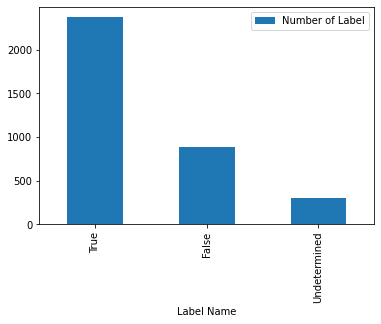

In [17]:
labelsDistributionDev = df['Label'].value_counts().rename_axis('Label Name').reset_index(name='Number of Label')
print(labelsDistributionDev)
labelsDistributionDev.plot(x='Label Name', y='Number of Label', kind="bar")

   Label Name  Number of Label
0           1              458
1           2              189
2           0               64


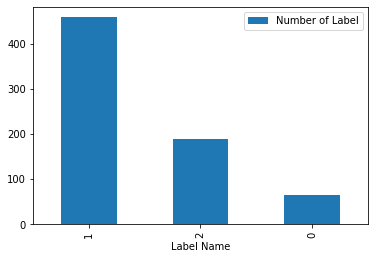

In [47]:
labelsDistributionTest = df_test['Label'].value_counts().rename_axis('Label Name').reset_index(name='Number of Label')
print(labelsDistributionTest)
labelsDistributionTest.plot(x='Label Name', y='Number of Label', kind="bar")

In [18]:
labels_dict = {"Undetermined" : 0, "True" : 1, "False" : 2 }
df['Label'] = df['Label'].map(labels_dict)


In [19]:
# # Get the lists of sentences and their labels.
# sentences1 = df.sentence1.values
# sentences2 = df.sentence2.values
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)

df = df_train
df_dev = df_test

sentences = df.sentence.values
labels = df.Label.values

sentences_dev = df_dev.sentence.values
labels_dev = df_dev.Label.values

In [20]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  No two things can occupy the same space at the same time. John and his car are in the same space. Therefore, John and his car are occupying the same space at the same time.
Tokenized:  ['no', 'two', 'things', 'can', 'occupy', 'the', 'same', 'space', 'at', 'the', 'same', 'time', '.', 'john', 'and', 'his', 'car', 'are', 'in', 'the', 'same', 'space', '.', 'therefore', ',', 'john', 'and', 'his', 'car', 'are', 'occupying', 'the', 'same', 'space', 'at', 'the', 'same', 'time', '.']
Token IDs:  [2053, 2048, 2477, 2064, 11494, 1996, 2168, 2686, 2012, 1996, 2168, 2051, 1012, 2198, 1998, 2010, 2482, 2024, 1999, 1996, 2168, 2686, 1012, 3568, 1010, 2198, 1998, 2010, 2482, 2024, 13992, 1996, 2168, 2686, 2012, 1996, 2168, 2051, 1012]


In [23]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  154


In [24]:
pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [26]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

input_ids_dev = []
attention_masks_dev = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# For every sentence...
for sent in sentences_dev:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_dev.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_dev.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_dev = torch.cat(input_ids_dev, dim=0)
attention_masks_dev = torch.cat(attention_masks_dev, dim=0)
labels_dev = torch.tensor(labels_dev)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  No two things can occupy the same space at the same time. John and his car are in the same space. Therefore, John and his car are occupying the same space at the same time.
Token IDs: tensor([  101,  2053,  2048,  2477,  2064, 11494,  1996,  2168,  2686,  2012,
         1996,  2168,  2051,  1012,  2198,  1998,  2010,  2482,  2024,  1999,
         1996,  2168,  2686,  1012,  3568,  1010,  2198,  1998,  2010,  2482,
         2024, 13992,  1996,  2168,  2686,  2012,  1996,  2168,  2051,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [27]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

dataset_dev = TensorDataset(input_ids_dev, attention_masks_dev, labels_dev);

train_dataset = dataset;
val_dataset = dataset_dev;


# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
#train_size = int(0.9 * len(dataset))
#val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#print('{:>5,} training samples'.format(train_size))
#print('{:>5,} validation samples'.format(val_size))

In [28]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [29]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    num_attention_heads = 24
)

# Tell pytorch to run this model on the GPU.
model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [30]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [32]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [34]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     89.    Elapsed: 0:00:29.
  Batch    80  of     89.    Elapsed: 0:00:56.

  Average training loss: 0.81
  Training epcoh took: 0:01:03

Running Validation...
  Accuracy: 0.65
  Validation Loss: 0.77
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     89.    Elapsed: 0:00:28.
  Batch    80  of     89.    Elapsed: 0:00:55.

  Average training loss: 0.64
  Training epcoh took: 0:01:01

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.66
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     89.    Elapsed: 0:00:28.
  Batch    80  of     89.    Elapsed: 0:00:55.

  Average training loss: 0.49
  Training epcoh took: 0:01:01

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.60
  Validation took: 0:00:06

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     89.    Elapsed: 0:00:28.
  Batch    80  of     89.    Elapsed: 0:

In [35]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.81,0.77,0.65,0:01:03,0:00:06
2,0.64,0.66,0.71,0:01:01,0:00:06
3,0.49,0.60,0.76,0:01:01,0:00:06
4,0.40,0.58,0.76,0:01:01,0:00:06


In [36]:
def tokenize_for_roberta_test(dataset):
  # Get the lists of sentences and their labels.
  sentences = dataset.sentence.values
  labels = dataset.Label.values
  max_len = 0

  # For every sentence...
  for sent in sentences:
      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

  print('Max sentence length: ', max_len)
  max_len = max(max_len, 128)
  print("Setting max_len to ", max_len )
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 128,           # Pad & truncate all sentences. In our case max was ~100
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])
  print("---------------------------------------------------------")
  # Combine the data inputs into a TensorDataset.
  from torch.utils.data import TensorDataset
  t_dataset = TensorDataset(input_ids, attention_masks, labels)
  return t_dataset, input_ids   



In [38]:
prediction_data, input_ids = tokenize_for_roberta_test(df_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


Max sentence length:  124
Setting max_len to  128
Original:  Apple and Google are stocks All stocks are publicly traded All stocks are subject to market fluctuations Apple is not subject to market fluctuations Google is not publicly traded Google is subject to market fluctuations
Token IDs: tensor([  101,  6207,  1998,  8224,  2024, 15768,  2035, 15768,  2024,  7271,
         7007,  2035, 15768,  2024,  3395,  2000,  3006, 28892,  6207,  2003,
         2025,  3395,  2000,  3006, 28892,  8224,  2003,  2025,  7271,  7007,
         8224,  2003,  3395,  2000,  3006, 28892,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [39]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  pred_labels = np.argmax(logits, axis=1)
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.extend(pred_labels.tolist())
  true_labels.extend(label_ids.tolist())

print('    DONE.')



Predicting labels for 711 test sentences...
    DONE.


In [40]:
from sklearn.metrics import classification_report

result_report = classification_report(true_labels, predictions, digits=3, output_dict=True)
#print(result_report)

In [41]:
result_report

{'0': {'precision': 0.5666666666666667,
  'recall': 0.265625,
  'f1-score': 0.36170212765957444,
  'support': 64},
 '1': {'precision': 0.8058823529411765,
  'recall': 0.8973799126637555,
  'f1-score': 0.8491735537190083,
  'support': 458},
 '2': {'precision': 0.6900584795321637,
  'recall': 0.6243386243386243,
  'f1-score': 0.6555555555555556,
  'support': 189},
 'accuracy': 0.7679324894514767,
 'macro avg': {'precision': 0.687535833046669,
  'recall': 0.5957811790007933,
  'f1-score': 0.6221437456447126,
  'support': 711},
 'weighted avg': {'precision': 0.7535609521031005,
  'recall': 0.7679324894514767,
  'f1-score': 0.7538261937742876,
  'support': 711}}

In [42]:
labels_num_to_name = { 0 : "Undetermined", 1 : "True", 2 : "False" }

new_result_report = dict()
for key in result_report:
  if key not in [str(x) for x in labels_num_to_name.keys()]:
    new_result_report[key] = result_report[key]
  else:
    new_result_report[labels_num_to_name[int(key)]] = result_report[key]


In [43]:
new_result_report

{'Undetermined': {'precision': 0.5666666666666667,
  'recall': 0.265625,
  'f1-score': 0.36170212765957444,
  'support': 64},
 'True': {'precision': 0.8058823529411765,
  'recall': 0.8973799126637555,
  'f1-score': 0.8491735537190083,
  'support': 458},
 'False': {'precision': 0.6900584795321637,
  'recall': 0.6243386243386243,
  'f1-score': 0.6555555555555556,
  'support': 189},
 'accuracy': 0.7679324894514767,
 'macro avg': {'precision': 0.687535833046669,
  'recall': 0.5957811790007933,
  'f1-score': 0.6221437456447126,
  'support': 711},
 'weighted avg': {'precision': 0.7535609521031005,
  'recall': 0.7679324894514767,
  'f1-score': 0.7538261937742876,
  'support': 711}}

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import json
with open('/content/drive/MyDrive/NLP_PROJECT/bert_attention_results_9_15.json','w') as f:
  json.dump(new_result_report,f)

Saving model

In [46]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/NLP_HW1_Data/bert_model_attention_v1/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))



Saving model to /content/drive/MyDrive/NLP_HW1_Data/bert_model_attention_v1/


('/content/drive/MyDrive/NLP_HW1_Data/bert_model_attention_v1/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_HW1_Data/bert_model_attention_v1/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_HW1_Data/bert_model_attention_v1/vocab.txt',
 '/content/drive/MyDrive/NLP_HW1_Data/bert_model_attention_v1/added_tokens.json')